In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import Model, layers
from keras.layers import Conv1D, LSTM, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Only display tensorflow errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-03-14 12:36:22.808339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741948582.818769 3712309 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741948582.821929 3712309 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741948582.830759 3712309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741948582.830768 3712309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741948582.830769 3712309 computation_placer.cc:177] computation placer alr

In [2]:
df = pd.read_csv('data/comp-merged.csv')
df = df[['value_acc', 'value_met']]
scaler = MinMaxScaler()
df['value_met'] = scaler.fit_transform(df['value_met'].values.reshape(-1, 1))
df['value_acc'] = scaler.transform(df['value_acc'].values.reshape(-1, 1))

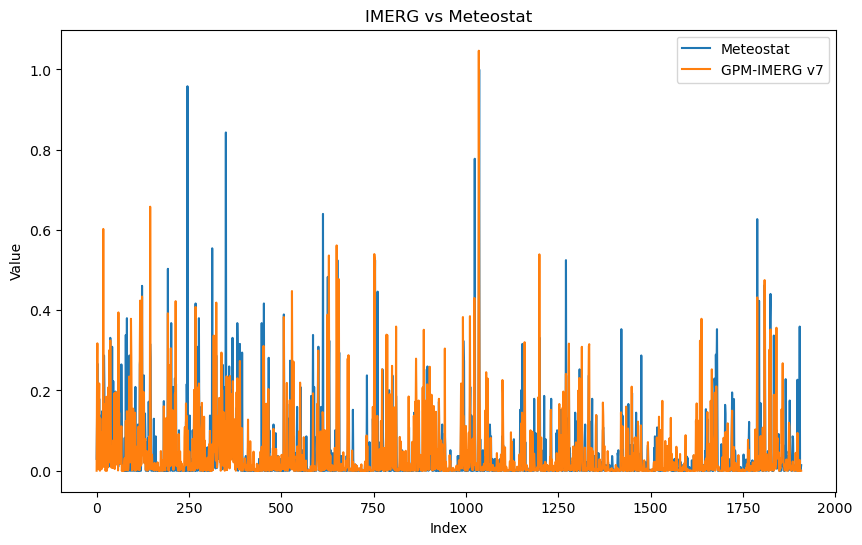

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['value_met'], label='Meteostat')
plt.plot(df['value_acc'], label='GPM-IMERG v7')
plt.title('IMERG vs Meteostat')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [4]:
batch_size = 4
epochs = 1000
window_size = 4

In [5]:
def windowed_dataset(data, window_size, batch_size, shuffle=True):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:, 0], axis=-1), tf.expand_dims(window[:, 1], axis=-1)))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
def windowed_dataset_single(data, window_size, batch_size):
    """
    Create a windowed dataset from the input data.

    Parameters:
    data (np.array): The input data array.
    window_size (int): The size of each window.
    batch_size (int): The size of each batch.

    Returns:
    tf.data.Dataset: The windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: tf.expand_dims(window, axis=-1))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
# Split the dataframe into train and test sets
train, test = train_test_split(df, test_size=0.1, shuffle=False)

train_set = windowed_dataset(train, window_size, batch_size, shuffle=False)
test_set = windowed_dataset(test, window_size, batch_size, shuffle=False)

I0000 00:00:1741948584.554557 3712309 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1010 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


2025-03-14 12:36:24.678861: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/tmp/ipykernel_3712309/2603999581.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(7624,)
(1909,)


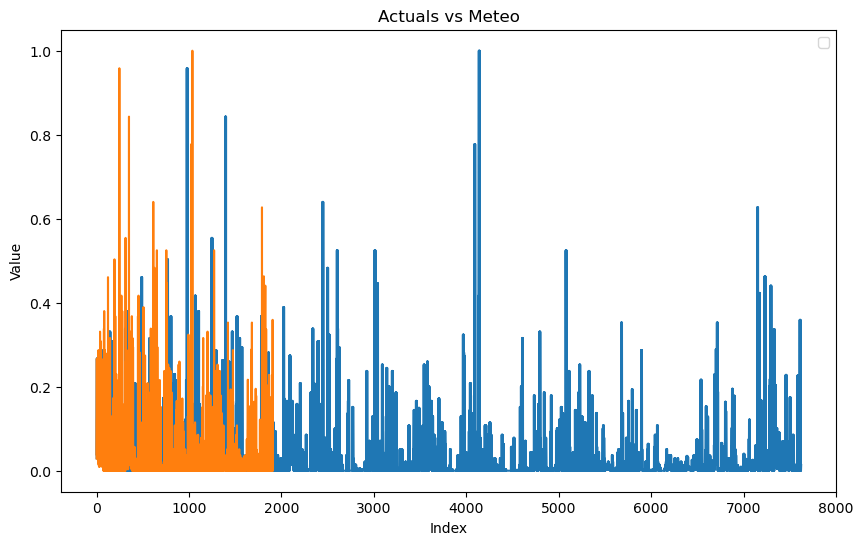

In [8]:
data = windowed_dataset(df, window_size, batch_size, shuffle=False)
actuals = [y for x, y in data]
actuals = np.concatenate(actuals, axis=0).flatten()

print(actuals.shape)
print(df['value_met'].shape)

plt.figure(figsize=(10, 6))
plt.plot(actuals)
plt.plot(df['value_met'])
plt.title('Actuals vs Meteo')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [20]:
class RootMeanSqauredError(keras.metrics.MeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, y_pred, sample_weight)

    def result(self):
        return tf.sqrt(super().result())

In [21]:
def build_model():
    """
    Build a CONV-LSTM model for error correction.
    
    Returns:
    keras.Model: The compiled model
    """
    # Input layer
    inputs = layers.Input(shape=(window_size, 1))
    
    # Convolutional layers
    x = Conv1D(filters=64, kernel_size=2, activation='relu', padding='same')(inputs)
    
    # LSTM layers
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32, return_sequences=True)(x)
    
    outputs = Conv1D(filters=1, kernel_size=1, activation='linear')(x)
    
    lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=2000,
        decay_rate=0.9
    )

    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.AdamW(lr_scheduler), loss='mse', metrics=['mae', RootMeanSqauredError(name='rmse')])
    
    return model

In [22]:
model = build_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 4, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 4, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 4, 1)           │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,665 (178.38 KB)

 Trainable params: 45,665 (178.38 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(
  train_set,
  epochs=epochs,
  validation_data=test_set,
  verbose=1,
  callbacks=[keras.callbacks.EarlyStopping(patience=10, monitor='val_rmse', min_delta=1e-6)]
)

Epoch 1/1000
    413/Unknown 2s 3ms/step - loss: 0.0116 - mae: 0.0660 - rmse: 0.1071

/home/edargham/anaconda3/envs/thesis/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0114 - mae: 0.0654 - rmse: 0.1064 - val_loss: 0.0082 - val_mae: 0.0429 - val_rmse: 0.0908
Epoch 2/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - mae: 0.0680 - rmse: 0.0954

2025-03-14 12:43:43.292968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:43.292983: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - mae: 0.0592 - rmse: 0.0951 - val_loss: 0.0075 - val_mae: 0.0418 - val_rmse: 0.0865
Epoch 3/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - mae: 0.0655 - rmse: 0.0902

2025-03-14 12:43:44.589832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:44.589846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - mae: 0.0559 - rmse: 0.0913 - val_loss: 0.0071 - val_mae: 0.0416 - val_rmse: 0.0840
Epoch 4/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - mae: 0.0641 - rmse: 0.0877

2025-03-14 12:43:45.889934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:45.889948: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - mae: 0.0548 - rmse: 0.0891 - val_loss: 0.0067 - val_mae: 0.0414 - val_rmse: 0.0820
Epoch 5/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - mae: 0.0630 - rmse: 0.0858

2025-03-14 12:43:47.184729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:47.184740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:43:47.184744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - mae: 0.0540 - rmse: 0.0875 - val_loss: 0.0065 - val_mae: 0.0409 - val_rmse: 0.0803
Epoch 6/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0621 - rmse: 0.0847

2025-03-14 12:43:48.484347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:48.484361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - mae: 0.0533 - rmse: 0.0864 - val_loss: 0.0063 - val_mae: 0.0403 - val_rmse: 0.0791
Epoch 7/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - mae: 0.0628 - rmse: 0.0852

2025-03-14 12:43:49.708001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:43:49.708016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:43:49.708019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:43:49.770270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:49.770280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - mae: 0.0527 - rmse: 0.0857 - val_loss: 0.0061 - val_mae: 0.0397 - val_rmse: 0.0783
Epoch 8/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0611 - rmse: 0.0839

2025-03-14 12:43:51.066143: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:51.066157: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - mae: 0.0522 - rmse: 0.0853 - val_loss: 0.0060 - val_mae: 0.0393 - val_rmse: 0.0777
Epoch 9/1000
 53/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0610 - rmse: 0.0840

2025-03-14 12:43:52.399959: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:52.399972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:43:52.399976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - mae: 0.0519 - rmse: 0.0850 - val_loss: 0.0060 - val_mae: 0.0389 - val_rmse: 0.0773
Epoch 10/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0607 - rmse: 0.0838

2025-03-14 12:43:53.721335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:53.721349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0516 - rmse: 0.0847 - val_loss: 0.0059 - val_mae: 0.0386 - val_rmse: 0.0771
Epoch 11/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0606 - rmse: 0.0838

2025-03-14 12:43:55.007288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:55.007302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0514 - rmse: 0.0845 - val_loss: 0.0059 - val_mae: 0.0384 - val_rmse: 0.0768
Epoch 12/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0605 - rmse: 0.0839

2025-03-14 12:43:56.292757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:56.292770: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0513 - rmse: 0.0844 - val_loss: 0.0059 - val_mae: 0.0383 - val_rmse: 0.0767
Epoch 13/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - mae: 0.0620 - rmse: 0.0855

2025-03-14 12:43:57.522770: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:43:57.522783: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:43:57.522786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:43:57.585319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:57.585331: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0512 - rmse: 0.0843 - val_loss: 0.0059 - val_mae: 0.0381 - val_rmse: 0.0766
Epoch 14/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0603 - rmse: 0.0839

2025-03-14 12:43:58.885986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:43:58.886000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0511 - rmse: 0.0842 - val_loss: 0.0058 - val_mae: 0.0380 - val_rmse: 0.0765
Epoch 15/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0602 - rmse: 0.0839

2025-03-14 12:44:00.191259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:00.191272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0510 - rmse: 0.0841 - val_loss: 0.0058 - val_mae: 0.0380 - val_rmse: 0.0764
Epoch 16/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0602 - rmse: 0.0839

2025-03-14 12:44:01.476231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:01.476245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0509 - rmse: 0.0840 - val_loss: 0.0058 - val_mae: 0.0379 - val_rmse: 0.0763
Epoch 17/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - mae: 0.0617 - rmse: 0.0855

2025-03-14 12:44:02.707846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:44:02.770717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:02.770731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0509 - rmse: 0.0839 - val_loss: 0.0058 - val_mae: 0.0378 - val_rmse: 0.0763
Epoch 18/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0601 - rmse: 0.0839

2025-03-14 12:44:04.063476: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:04.063489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0508 - rmse: 0.0839 - val_loss: 0.0058 - val_mae: 0.0378 - val_rmse: 0.0762
Epoch 19/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0601 - rmse: 0.0838

2025-03-14 12:44:05.359166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:05.359177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0508 - rmse: 0.0838 - val_loss: 0.0058 - val_mae: 0.0378 - val_rmse: 0.0762
Epoch 20/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0601 - rmse: 0.0838

2025-03-14 12:44:06.660759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:06.660773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0507 - rmse: 0.0838 - val_loss: 0.0058 - val_mae: 0.0377 - val_rmse: 0.0761
Epoch 21/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0600 - rmse: 0.0837

2025-03-14 12:44:07.958331: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:07.958343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0507 - rmse: 0.0837 - val_loss: 0.0058 - val_mae: 0.0377 - val_rmse: 0.0761
Epoch 22/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - mae: 0.0616 - rmse: 0.0853

2025-03-14 12:44:09.187931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:44:09.250039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:09.250049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0506 - rmse: 0.0837 - val_loss: 0.0058 - val_mae: 0.0377 - val_rmse: 0.0761
Epoch 23/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - mae: 0.0615 - rmse: 0.0853

2025-03-14 12:44:10.480246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:44:10.480261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:44:10.480265: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:44:10.542919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:10.542934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0505 - rmse: 0.0836 - val_loss: 0.0058 - val_mae: 0.0376 - val_rmse: 0.0761
Epoch 24/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0598 - rmse: 0.0836

2025-03-14 12:44:11.841484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:11.841498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0505 - rmse: 0.0836 - val_loss: 0.0058 - val_mae: 0.0376 - val_rmse: 0.0760
Epoch 25/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0598 - rmse: 0.0836

2025-03-14 12:44:13.146457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:13.146472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0504 - rmse: 0.0835 - val_loss: 0.0058 - val_mae: 0.0376 - val_rmse: 0.0760
Epoch 26/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0597 - rmse: 0.0835

2025-03-14 12:44:14.442161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:14.442175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0504 - rmse: 0.0835 - val_loss: 0.0058 - val_mae: 0.0376 - val_rmse: 0.0760
Epoch 27/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0596 - rmse: 0.0834

2025-03-14 12:44:15.735047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:15.735060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0503 - rmse: 0.0835 - val_loss: 0.0058 - val_mae: 0.0376 - val_rmse: 0.0760
Epoch 28/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0596 - rmse: 0.0834

2025-03-14 12:44:17.024429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:17.024441: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:17.024445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0503 - rmse: 0.0834 - val_loss: 0.0058 - val_mae: 0.0375 - val_rmse: 0.0759
Epoch 29/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0596 - rmse: 0.0834

2025-03-14 12:44:18.318181: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:18.318192: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0502 - rmse: 0.0834 - val_loss: 0.0058 - val_mae: 0.0375 - val_rmse: 0.0759
Epoch 30/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0596 - rmse: 0.0834

2025-03-14 12:44:19.618793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:19.618807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0502 - rmse: 0.0834 - val_loss: 0.0058 - val_mae: 0.0375 - val_rmse: 0.0759
Epoch 31/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - mae: 0.0611 - rmse: 0.0848

2025-03-14 12:44:20.851189: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:44:20.851204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:44:20.851208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:44:20.914432: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:20.914442: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:20.914446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0501 - rmse: 0.0833 - val_loss: 0.0058 - val_mae: 0.0375 - val_rmse: 0.0759
Epoch 32/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0594 - rmse: 0.0832

2025-03-14 12:44:22.207192: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:22.207206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0501 - rmse: 0.0833 - val_loss: 0.0058 - val_mae: 0.0375 - val_rmse: 0.0759
Epoch 33/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0593 - rmse: 0.0831

2025-03-14 12:44:23.498057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:23.498069: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0500 - rmse: 0.0833 - val_loss: 0.0058 - val_mae: 0.0375 - val_rmse: 0.0759
Epoch 34/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0594 - rmse: 0.0833

2025-03-14 12:44:24.792142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:24.792156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0500 - rmse: 0.0833 - val_loss: 0.0058 - val_mae: 0.0375 - val_rmse: 0.0759
Epoch 35/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0593 - rmse: 0.0831

2025-03-14 12:44:26.092184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:26.092199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:26.092204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0500 - rmse: 0.0832 - val_loss: 0.0058 - val_mae: 0.0375 - val_rmse: 0.0759
Epoch 36/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0592 - rmse: 0.0831

2025-03-14 12:44:27.386815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:27.386829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0499 - rmse: 0.0832 - val_loss: 0.0058 - val_mae: 0.0375 - val_rmse: 0.0758
Epoch 37/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0592 - rmse: 0.0831

2025-03-14 12:44:28.683480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:28.683493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0499 - rmse: 0.0832 - val_loss: 0.0058 - val_mae: 0.0375 - val_rmse: 0.0758
Epoch 38/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0592 - rmse: 0.0831

2025-03-14 12:44:29.977889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:29.977903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:29.977907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0498 - rmse: 0.0832 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0758
Epoch 39/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0591 - rmse: 0.0830

2025-03-14 12:44:31.269296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:31.269307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:31.269311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0498 - rmse: 0.0832 - val_loss: 0.0057 - val_mae: 0.0374 - val_rmse: 0.0758
Epoch 40/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0591 - rmse: 0.0830

2025-03-14 12:44:32.566421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:32.566435: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:32.566439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0497 - rmse: 0.0831 - val_loss: 0.0057 - val_mae: 0.0374 - val_rmse: 0.0758
Epoch 41/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0590 - rmse: 0.0830

2025-03-14 12:44:33.867884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:33.867896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:33.867899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0497 - rmse: 0.0831 - val_loss: 0.0057 - val_mae: 0.0374 - val_rmse: 0.0758
Epoch 42/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0590 - rmse: 0.0829

2025-03-14 12:44:35.164531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:35.164542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:35.164546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0497 - rmse: 0.0831 - val_loss: 0.0057 - val_mae: 0.0374 - val_rmse: 0.0758
Epoch 43/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0606 - rmse: 0.0844

2025-03-14 12:44:36.397154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:44:36.397168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:44:36.460108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:36.460116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0496 - rmse: 0.0831 - val_loss: 0.0057 - val_mae: 0.0374 - val_rmse: 0.0758
Epoch 44/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0590 - rmse: 0.0830

2025-03-14 12:44:37.751328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:37.751344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0496 - rmse: 0.0831 - val_loss: 0.0057 - val_mae: 0.0374 - val_rmse: 0.0758
Epoch 45/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0589 - rmse: 0.0828

2025-03-14 12:44:39.045644: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:39.045659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0495 - rmse: 0.0831 - val_loss: 0.0057 - val_mae: 0.0374 - val_rmse: 0.0757
Epoch 46/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0828

2025-03-14 12:44:40.341077: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:40.341090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0495 - rmse: 0.0831 - val_loss: 0.0057 - val_mae: 0.0374 - val_rmse: 0.0757
Epoch 47/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0828

2025-03-14 12:44:41.636105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:41.636117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:41.636121: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0495 - rmse: 0.0830 - val_loss: 0.0057 - val_mae: 0.0374 - val_rmse: 0.0757
Epoch 48/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0604 - rmse: 0.0842

2025-03-14 12:44:42.872271: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:44:42.872285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:44:42.934920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:42.934935: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0494 - rmse: 0.0830 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0757
Epoch 49/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0828

2025-03-14 12:44:44.229588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:44.229602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0494 - rmse: 0.0830 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0757
Epoch 50/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0604 - rmse: 0.0842

2025-03-14 12:44:45.466060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:44:45.466076: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:44:45.466080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:44:45.530620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:45.530632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0494 - rmse: 0.0830 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0757
Epoch 51/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0827

2025-03-14 12:44:46.829233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:46.829246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0493 - rmse: 0.0830 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0757
Epoch 52/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0586 - rmse: 0.0827

2025-03-14 12:44:48.121283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:48.121296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:48.121300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0493 - rmse: 0.0830 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0757
Epoch 53/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0586 - rmse: 0.0827

2025-03-14 12:44:49.418869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:49.418881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0492 - rmse: 0.0830 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0757
Epoch 54/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0586 - rmse: 0.0827

2025-03-14 12:44:50.711079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:50.711093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0492 - rmse: 0.0830 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0756
Epoch 55/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0585 - rmse: 0.0826

2025-03-14 12:44:52.014120: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:52.014136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:52.014140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0492 - rmse: 0.0830 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0756
Epoch 56/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0602 - rmse: 0.0840

2025-03-14 12:44:53.242401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:44:53.242418: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:44:53.242421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:44:53.304935: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:53.304945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:44:53.304949: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0491 - rmse: 0.0830 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0756
Epoch 57/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0602 - rmse: 0.0840

2025-03-14 12:44:54.540694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:44:54.540708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:44:54.540710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:44:54.604519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:54.604533: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0491 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0756
Epoch 58/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0584 - rmse: 0.0826

2025-03-14 12:44:55.897954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:55.897969: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0491 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0756
Epoch 59/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0584 - rmse: 0.0825

2025-03-14 12:44:57.190199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:57.190214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0490 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0756
Epoch 60/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0584 - rmse: 0.0825

2025-03-14 12:44:58.485006: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:58.485018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0490 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0756
Epoch 61/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0584 - rmse: 0.0825

2025-03-14 12:44:59.781779: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:44:59.781793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0490 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0375 - val_rmse: 0.0756
Epoch 62/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0583 - rmse: 0.0825

2025-03-14 12:45:01.074003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:01.074017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0489 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0376 - val_rmse: 0.0755
Epoch 63/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0600 - rmse: 0.0838

2025-03-14 12:45:02.309536: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:45:02.373144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:02.373154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0489 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0376 - val_rmse: 0.0755
Epoch 64/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0584 - rmse: 0.0825

2025-03-14 12:45:03.666685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:03.666700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0489 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0376 - val_rmse: 0.0755
Epoch 65/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0583 - rmse: 0.0824

2025-03-14 12:45:04.977378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:04.977390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0489 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0376 - val_rmse: 0.0755
Epoch 66/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0583 - rmse: 0.0825

2025-03-14 12:45:06.276716: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:06.276733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0488 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0376 - val_rmse: 0.0755
Epoch 67/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0582 - rmse: 0.0824

2025-03-14 12:45:07.570811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:07.570825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0488 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0376 - val_rmse: 0.0755
Epoch 68/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0581 - rmse: 0.0823

2025-03-14 12:45:08.865130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:08.865144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:45:08.865148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0488 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0376 - val_rmse: 0.0755
Epoch 69/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0582 - rmse: 0.0824

2025-03-14 12:45:10.156926: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:10.156937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:45:10.156940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0487 - rmse: 0.0829 - val_loss: 0.0057 - val_mae: 0.0376 - val_rmse: 0.0755
Epoch 70/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0581 - rmse: 0.0823

2025-03-14 12:45:11.459392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:11.459406: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0487 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0377 - val_rmse: 0.0754
Epoch 71/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0581 - rmse: 0.0823

2025-03-14 12:45:12.760979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:12.760992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0487 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0377 - val_rmse: 0.0754
Epoch 72/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0581 - rmse: 0.0823

2025-03-14 12:45:14.055532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:14.055545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0487 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0377 - val_rmse: 0.0754
Epoch 73/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0580 - rmse: 0.0822

2025-03-14 12:45:15.347503: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:15.347516: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0486 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0377 - val_rmse: 0.0754
Epoch 74/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0597 - rmse: 0.0835

2025-03-14 12:45:16.571530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:45:16.571544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:45:16.633247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:16.633258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0486 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0377 - val_rmse: 0.0754
Epoch 75/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0580 - rmse: 0.0822

2025-03-14 12:45:17.929522: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:17.929537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0486 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0377 - val_rmse: 0.0754
Epoch 76/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0581 - rmse: 0.0823

2025-03-14 12:45:19.224479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:19.224492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:45:19.224497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0486 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0377 - val_rmse: 0.0754
Epoch 77/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0580 - rmse: 0.0822

2025-03-14 12:45:20.519372: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:20.519386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0485 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0378 - val_rmse: 0.0754
Epoch 78/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0580 - rmse: 0.0822

2025-03-14 12:45:21.812184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:21.812197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0485 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0378 - val_rmse: 0.0753
Epoch 79/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mae: 0.0596 - rmse: 0.0834

2025-03-14 12:45:23.040334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:45:23.102676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:23.102688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0485 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0378 - val_rmse: 0.0753
Epoch 80/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0579 - rmse: 0.0821

2025-03-14 12:45:24.404701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:24.404714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0485 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0378 - val_rmse: 0.0753
Epoch 81/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0579 - rmse: 0.0821

2025-03-14 12:45:25.705515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:25.705527: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0485 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0378 - val_rmse: 0.0753
Epoch 82/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0578 - rmse: 0.0820

2025-03-14 12:45:27.001373: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:27.001385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0484 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0378 - val_rmse: 0.0753
Epoch 83/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0579 - rmse: 0.0821

2025-03-14 12:45:28.294624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:28.294636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0484 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0379 - val_rmse: 0.0753
Epoch 84/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0579 - rmse: 0.0821

2025-03-14 12:45:29.590985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:29.590996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:45:29.591000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0484 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0379 - val_rmse: 0.0753
Epoch 85/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0578 - rmse: 0.0820

2025-03-14 12:45:30.886284: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:30.886298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0484 - rmse: 0.0828 - val_loss: 0.0057 - val_mae: 0.0379 - val_rmse: 0.0753
Epoch 86/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0594 - rmse: 0.0833

2025-03-14 12:45:32.114317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:45:32.177819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:32.177829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0484 - rmse: 0.0827 - val_loss: 0.0057 - val_mae: 0.0379 - val_rmse: 0.0753
Epoch 87/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0578 - rmse: 0.0820

2025-03-14 12:45:33.472323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:33.472337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0484 - rmse: 0.0827 - val_loss: 0.0057 - val_mae: 0.0379 - val_rmse: 0.0752
Epoch 88/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0594 - rmse: 0.0833

2025-03-14 12:45:34.706472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:45:34.768171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:34.768181: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0483 - rmse: 0.0827 - val_loss: 0.0057 - val_mae: 0.0380 - val_rmse: 0.0752
Epoch 89/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0578 - rmse: 0.0820

2025-03-14 12:45:36.065404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:36.065417: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0483 - rmse: 0.0827 - val_loss: 0.0057 - val_mae: 0.0380 - val_rmse: 0.0752
Epoch 90/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0578 - rmse: 0.0820

2025-03-14 12:45:37.360811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:37.360824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0483 - rmse: 0.0827 - val_loss: 0.0057 - val_mae: 0.0380 - val_rmse: 0.0752
Epoch 91/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0593 - rmse: 0.0832

2025-03-14 12:45:38.591294: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-03-14 12:45:38.654204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:38.654213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:45:38.654218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0483 - rmse: 0.0827 - val_loss: 0.0057 - val_mae: 0.0380 - val_rmse: 0.0752
Epoch 92/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0578 - rmse: 0.0819

2025-03-14 12:45:39.948130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046
2025-03-14 12:45:39.948148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0483 - rmse: 0.0827 - val_loss: 0.0057 - val_mae: 0.0380 - val_rmse: 0.0752
Epoch 93/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0577 - rmse: 0.0819

2025-03-14 12:45:41.241823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:41.241838: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0483 - rmse: 0.0827 - val_loss: 0.0057 - val_mae: 0.0380 - val_rmse: 0.0752
Epoch 94/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0577 - rmse: 0.0819

2025-03-14 12:45:42.538700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:42.538712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0482 - rmse: 0.0827 - val_loss: 0.0057 - val_mae: 0.0381 - val_rmse: 0.0752
Epoch 95/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0593 - rmse: 0.0831

2025-03-14 12:45:43.786108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:45:43.786124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:45:43.849888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:43.849899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0482 - rmse: 0.0827 - val_loss: 0.0057 - val_mae: 0.0381 - val_rmse: 0.0752
Epoch 96/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0577 - rmse: 0.0819

2025-03-14 12:45:45.156576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:45.156588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0482 - rmse: 0.0827 - val_loss: 0.0056 - val_mae: 0.0381 - val_rmse: 0.0752
Epoch 97/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0578 - rmse: 0.0819

2025-03-14 12:45:46.455043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:46.455055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0482 - rmse: 0.0827 - val_loss: 0.0056 - val_mae: 0.0381 - val_rmse: 0.0752
Epoch 98/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0592 - rmse: 0.0831

2025-03-14 12:45:47.683687: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:45:47.683702: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:45:47.683706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:45:47.747090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:47.747102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:45:47.747106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0482 - rmse: 0.0827 - val_loss: 0.0056 - val_mae: 0.0381 - val_rmse: 0.0751
Epoch 99/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0577 - rmse: 0.0819

2025-03-14 12:45:49.040844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:49.040857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0482 - rmse: 0.0827 - val_loss: 0.0056 - val_mae: 0.0381 - val_rmse: 0.0751
Epoch 100/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0577 - rmse: 0.0818

2025-03-14 12:45:50.346570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:50.346586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0482 - rmse: 0.0827 - val_loss: 0.0056 - val_mae: 0.0382 - val_rmse: 0.0751
Epoch 101/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0577 - rmse: 0.0818

2025-03-14 12:45:51.647391: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:51.647405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0482 - rmse: 0.0827 - val_loss: 0.0056 - val_mae: 0.0382 - val_rmse: 0.0751
Epoch 102/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0592 - rmse: 0.0830

2025-03-14 12:45:52.881929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:45:52.881944: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:45:52.881948: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:45:52.944424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:52.944435: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0481 - rmse: 0.0827 - val_loss: 0.0056 - val_mae: 0.0382 - val_rmse: 0.0751
Epoch 103/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0576 - rmse: 0.0818

2025-03-14 12:45:54.237844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:54.237858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0481 - rmse: 0.0827 - val_loss: 0.0056 - val_mae: 0.0382 - val_rmse: 0.0751
Epoch 104/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0577 - rmse: 0.0819

2025-03-14 12:45:55.529920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:55.529932: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0481 - rmse: 0.0827 - val_loss: 0.0056 - val_mae: 0.0382 - val_rmse: 0.0751
Epoch 105/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0576 - rmse: 0.0818

2025-03-14 12:45:56.824754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:56.824767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0481 - rmse: 0.0827 - val_loss: 0.0056 - val_mae: 0.0382 - val_rmse: 0.0751
Epoch 106/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0817

2025-03-14 12:45:58.118346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:58.118358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0481 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0383 - val_rmse: 0.0751
Epoch 107/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0577 - rmse: 0.0818

2025-03-14 12:45:59.407387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:45:59.407403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0481 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0383 - val_rmse: 0.0751
Epoch 108/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0576 - rmse: 0.0818

2025-03-14 12:46:00.707682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:00.707695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0481 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0383 - val_rmse: 0.0751
Epoch 109/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0577 - rmse: 0.0818

2025-03-14 12:46:02.004646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:02.004660: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0481 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0383 - val_rmse: 0.0751
Epoch 110/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0576 - rmse: 0.0817

2025-03-14 12:46:03.309033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:03.309046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0481 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0383 - val_rmse: 0.0751
Epoch 111/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0577 - rmse: 0.0818

2025-03-14 12:46:04.600332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:04.600351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0383 - val_rmse: 0.0750
Epoch 112/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0576 - rmse: 0.0817

2025-03-14 12:46:05.896186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:05.896198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0384 - val_rmse: 0.0750
Epoch 113/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0576 - rmse: 0.0817

2025-03-14 12:46:07.192682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:07.192692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:46:07.192695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0384 - val_rmse: 0.0750
Epoch 114/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - mae: 0.0576 - rmse: 0.0818

2025-03-14 12:46:08.487112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:08.487126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0384 - val_rmse: 0.0750
Epoch 115/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0817

2025-03-14 12:46:09.789254: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:09.789268: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0384 - val_rmse: 0.0750
Epoch 116/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0817

2025-03-14 12:46:11.085151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:11.085164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0384 - val_rmse: 0.0750
Epoch 117/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0817

2025-03-14 12:46:12.379031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:12.379044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0384 - val_rmse: 0.0750
Epoch 118/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0817

2025-03-14 12:46:13.670438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:13.670453: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0385 - val_rmse: 0.0750
Epoch 119/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0817

2025-03-14 12:46:14.965722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:14.965735: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0385 - val_rmse: 0.0750
Epoch 120/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0590 - rmse: 0.0828

2025-03-14 12:46:16.205790: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:46:16.269461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:16.269473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0385 - val_rmse: 0.0750
Epoch 121/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0816

2025-03-14 12:46:17.568825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:17.568841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0385 - val_rmse: 0.0750
Epoch 122/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0816

2025-03-14 12:46:18.864973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:18.864986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0385 - val_rmse: 0.0750
Epoch 123/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0816

2025-03-14 12:46:20.160506: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:20.160518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0385 - val_rmse: 0.0750
Epoch 124/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0576 - rmse: 0.0817

2025-03-14 12:46:21.454497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:21.454510: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0385 - val_rmse: 0.0750
Epoch 125/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0589 - rmse: 0.0828

2025-03-14 12:46:22.687570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:46:22.751402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:22.751414: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0480 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0385 - val_rmse: 0.0750
Epoch 126/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0816

2025-03-14 12:46:24.046612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:24.046625: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0386 - val_rmse: 0.0750
Epoch 127/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0816

2025-03-14 12:46:25.338879: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:25.338890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0386 - val_rmse: 0.0750
Epoch 128/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0816

2025-03-14 12:46:26.636554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:26.636568: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0386 - val_rmse: 0.0750
Epoch 129/1000
 36/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0589 - rmse: 0.0827

2025-03-14 12:46:27.872882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:46:27.872899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:46:27.872902: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:46:27.936256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:27.936267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0386 - val_rmse: 0.0749
Epoch 130/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0816

2025-03-14 12:46:29.246099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:29.246114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0386 - val_rmse: 0.0749
Epoch 131/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0816

2025-03-14 12:46:30.542180: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:30.542194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0386 - val_rmse: 0.0749
Epoch 132/1000
 38/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0589 - rmse: 0.0827

2025-03-14 12:46:31.913929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:46:31.913945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:46:31.913949: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:46:31.985520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:31.985529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:46:31.985532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0386 - val_rmse: 0.0749
Epoch 133/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0816

2025-03-14 12:46:33.278699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:33.278711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:46:33.278714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0386 - val_rmse: 0.0749
Epoch 134/1000
 53/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0576 - rmse: 0.0817

2025-03-14 12:46:34.576374: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:34.576387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0387 - val_rmse: 0.0749
Epoch 135/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0816

2025-03-14 12:46:35.884625: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:35.884638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:46:35.884641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0826 - val_loss: 0.0056 - val_mae: 0.0387 - val_rmse: 0.0749
Epoch 136/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0815

2025-03-14 12:46:37.178455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:37.178470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0387 - val_rmse: 0.0749
Epoch 137/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0815

2025-03-14 12:46:38.469386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:38.469399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0387 - val_rmse: 0.0749
Epoch 138/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0815

2025-03-14 12:46:39.763001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:39.763016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0387 - val_rmse: 0.0749
Epoch 139/1000
 36/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0827

2025-03-14 12:46:40.999150: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:46:40.999166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:46:40.999169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:46:41.062038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:41.062049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0387 - val_rmse: 0.0749
Epoch 140/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:46:42.367738: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:42.367753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0387 - val_rmse: 0.0749
Epoch 141/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:46:43.668659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:43.668671: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0387 - val_rmse: 0.0749
Epoch 142/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:46:44.961798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:44.961809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0387 - val_rmse: 0.0749
Epoch 143/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:46:46.253172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:46.253185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0387 - val_rmse: 0.0749
Epoch 144/1000
 36/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0826

2025-03-14 12:46:47.484286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:46:47.546081: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:47.546092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 145/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:46:48.847147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:48.847161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 146/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0827

2025-03-14 12:46:50.075865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:46:50.140278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:50.140290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:46:50.140294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 147/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:46:51.434881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:51.434895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 148/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:46:52.734988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:52.735000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:46:52.735004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 149/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:46:54.027773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:54.027786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0479 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 150/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:46:55.326918: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:55.326932: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 151/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0826

2025-03-14 12:46:56.554368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:46:56.617630: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:56.617655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 152/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:46:57.910805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:57.910818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 153/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:46:59.202122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:46:59.202135: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 154/1000
 36/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0826

2025-03-14 12:47:00.437815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:47:00.437828: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:47:00.437831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:47:00.499983: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:00.499994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 155/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:47:01.811187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:01.811201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0388 - val_rmse: 0.0749
Epoch 156/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0826

2025-03-14 12:47:03.044805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:47:03.044818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:47:03.044821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:47:03.108605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:03.108617: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 157/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0815

2025-03-14 12:47:04.403821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:04.403834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 158/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:47:05.697899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:05.697910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 159/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:47:06.987218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:06.987230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 160/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0815

2025-03-14 12:47:08.286968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:08.286981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 161/1000
 53/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0576 - rmse: 0.0816

2025-03-14 12:47:09.593826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:09.593840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 162/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0826

2025-03-14 12:47:10.830840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:47:10.830855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:47:10.830858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:47:10.893676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:10.893689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 163/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:12.186052: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:12.186064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 164/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:13.480839: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:13.480852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 165/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:14.774574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:14.774589: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 166/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:16.066922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:16.066936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 167/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:17.369464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:17.369479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 168/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:18.669473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:18.669485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0749
Epoch 169/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:19.969071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:19.969083: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:47:19.969087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0748
Epoch 170/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:21.266210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:21.266223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0389 - val_rmse: 0.0748
Epoch 171/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:22.560695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:22.560708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 172/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0815

2025-03-14 12:47:23.851816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:23.851829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 173/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:25.160594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:25.160607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 174/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:26.454988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:26.455002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 175/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:27.752550: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:27.752568: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 176/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:29.048817: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:29.048830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 177/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:30.351066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:30.351078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 178/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0825

2025-03-14 12:47:31.579219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:47:31.579234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:47:31.579237: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:47:31.641852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:31.641861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 179/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:32.951742: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:32.951755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 180/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0815

2025-03-14 12:47:34.244732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:34.244746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 181/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:35.543220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:35.543232: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:47:35.543236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 182/1000
 36/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:47:36.778178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:47:36.778195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:47:36.778198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:47:36.840375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:36.840384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 183/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0588 - rmse: 0.0825

2025-03-14 12:47:38.076519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:47:38.076534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:47:38.076537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:47:38.139672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:38.139682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 184/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:39.431389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:39.431410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 185/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:40.741998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:40.742011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 186/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:42.038199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:42.038213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 187/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:43.332542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:43.332555: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 188/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:44.629503: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:44.629516: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 189/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:45.924638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:45.924651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 190/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0815

2025-03-14 12:47:47.220426: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:47.220440: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 191/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:48.545582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:48.545595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 192/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0815

2025-03-14 12:47:49.843205: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:49.843217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 193/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:51.143865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:51.143878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 194/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0573 - rmse: 0.0813

2025-03-14 12:47:52.442974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:52.442989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0390 - val_rmse: 0.0748
Epoch 195/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:53.733561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:53.733575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 196/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:55.036072: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:55.036085: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 197/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:56.346063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:56.346075: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:47:56.346079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 198/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:57.648416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:57.648429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 199/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:47:58.944350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:47:58.944363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 200/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:00.233487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:00.233500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 201/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:01.527399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:01.527411: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 202/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:02.823014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:02.823027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 203/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:48:04.075630: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:48:04.138874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:04.138885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 204/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:05.443396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:05.443408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 205/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:06.740408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:06.740420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 206/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:08.037377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:08.037389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 207/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0814

2025-03-14 12:48:09.333014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:09.333025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 208/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0573 - rmse: 0.0813

2025-03-14 12:48:10.634905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:10.634919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:48:10.634923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 209/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:48:11.888934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:48:11.952257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:11.952268: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 210/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:13.254438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:13.254451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 211/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:14.557194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:14.557211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 212/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:15.859610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:15.859622: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:48:15.859626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 213/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:17.158064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:17.158078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 214/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:18.453188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:18.453199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 215/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:19.764190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:19.764202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 216/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:21.062573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:21.062586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:48:21.062590: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 217/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:22.354624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:22.354636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:48:22.354640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 218/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:23.657807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:23.657821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 219/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0814

2025-03-14 12:48:24.956826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:24.956840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 220/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:26.260476: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046
2025-03-14 12:48:26.260491: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 221/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:27.565063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:27.565075: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 222/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:28.866042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:28.866055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 223/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:48:30.093028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:48:30.093041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:48:30.093044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:48:30.156799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:30.156811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 224/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:31.457756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:31.457768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 225/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:48:32.691924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:48:32.691940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:48:32.691944: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:48:32.755029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:32.755039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 226/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:34.052429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:34.052440: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:48:34.052444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 227/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:35.365387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:35.365401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 228/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:36.668709: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:36.668723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 229/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:37.965866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:37.965880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 230/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:39.265596: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:39.265609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:48:39.265613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 231/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:40.567253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:40.567266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 232/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:48:41.803604: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:48:41.803619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:48:41.867337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:41.867350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0825 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 233/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:43.176197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:43.176211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 234/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:48:44.414700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:48:44.478119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:44.478130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 235/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:45.778678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:45.778690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 236/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0814

2025-03-14 12:48:47.076495: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:47.076509: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 237/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:48.381546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:48.381559: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 238/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:49.678553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:49.678566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 239/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0814

2025-03-14 12:48:50.990622: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:50.990634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 240/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:48:52.233203: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:48:52.297126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:52.297139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 241/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:48:53.532760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:48:53.532774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:48:53.532778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:48:53.595079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:53.595090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 242/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:48:54.836677: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:48:54.836694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:48:54.836699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:48:54.899617: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:54.899628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 243/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0814

2025-03-14 12:48:56.203487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:56.203500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 244/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:48:57.500283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:57.500297: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 245/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:48:58.808823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:48:58.808837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 246/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:00.104783: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:00.104798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 247/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:01.397550: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:01.397563: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 248/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:49:02.636189: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:49:02.636204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:49:02.636207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:49:02.700537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:02.700548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0391 - val_rmse: 0.0748
Epoch 249/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:03.995148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:03.995162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 250/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:05.293819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:05.293832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 251/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:06.601023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:06.601035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 252/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:07.900810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:07.900822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:49:07.900825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 253/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:09.188860: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:09.188872: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:49:09.188876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 254/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:10.487544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:10.487556: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:49:10.487559: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 255/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:11.781245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:11.781262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 256/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:13.080087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:13.080101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 257/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:49:14.324678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:49:14.389673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:14.389690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 258/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:15.694614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:15.694630: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 259/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0573 - rmse: 0.0813

2025-03-14 12:49:16.990479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:16.990492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 260/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:49:18.223163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:49:18.223180: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:49:18.223184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:49:18.285445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:18.285457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 261/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:19.579073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:19.579085: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 262/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:20.873997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:20.874011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 263/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:22.204813: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:22.204828: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 264/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0814

2025-03-14 12:49:23.509690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:23.509704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 265/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:49:24.740642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:49:24.805362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:24.805376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 266/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:26.111115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:26.111129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 267/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:49:27.345312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:49:27.345327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:49:27.345330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:49:27.408259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:27.408272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 268/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:28.702054: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:28.702065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 269/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:30.011585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:30.011599: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 270/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:49:31.246879: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:49:31.246893: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:49:31.310000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:31.310011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 271/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0814

2025-03-14 12:49:32.605534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:32.605546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 272/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:49:33.840836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16947107706658714297
2025-03-14 12:49:33.840850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:49:33.840854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:49:33.903390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:33.903400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 273/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0573 - rmse: 0.0813

2025-03-14 12:49:35.200208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:35.200221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 274/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:49:36.429062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:49:36.429077: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:49:36.492521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:36.492535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 275/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:37.800346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:37.800359: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 276/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:39.097214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:39.097227: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 277/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:40.395031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:40.395043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:49:40.395047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 278/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:41.695437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:41.695453: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 279/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:42.990321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:42.990334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 280/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:44.283836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:44.283850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 281/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:45.598909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:45.598923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 282/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0573 - rmse: 0.0813

2025-03-14 12:49:46.898374: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:46.898388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 283/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:48.193687: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:48.193700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 284/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:49.490483: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:49.490495: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 285/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:49:50.732363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:49:50.732375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:49:50.795826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:50.795837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 286/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:52.089366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:52.089379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 287/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0814

2025-03-14 12:49:53.397228: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:53.397241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:49:53.397245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 288/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0573 - rmse: 0.0813

2025-03-14 12:49:54.702095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:54.702109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 289/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:55.994184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:55.994196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 290/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:57.292293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:57.292306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 291/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:49:58.587114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:58.587129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 774482087661723621
2025-03-14 12:49:58.587133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 292/1000
 56/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0573 - rmse: 0.0813

2025-03-14 12:49:59.884659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:49:59.884672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 293/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:50:01.195402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:50:01.195415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 294/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:50:02.492095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:50:02.492108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 295/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:50:03.792650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:50:03.792662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 296/1000
 37/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0587 - rmse: 0.0825

2025-03-14 12:50:05.025709: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1552407629382582700
2025-03-14 12:50:05.025724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8997626385840146114
2025-03-14 12:50:05.089047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:50:05.089059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 297/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:50:06.391444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:50:06.391456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 298/1000
 54/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0814

2025-03-14 12:50:07.693050: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:50:07.693064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 299/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:50:09.006606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:50:09.006621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748
Epoch 300/1000
 55/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0813

2025-03-14 12:50:10.302644: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:50:10.302658: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - mae: 0.0478 - rmse: 0.0824 - val_loss: 0.0056 - val_mae: 0.0392 - val_rmse: 0.0748


2025-03-14 12:50:11.603225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7933217067335299467
2025-03-14 12:50:11.603237: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11091523724926713046


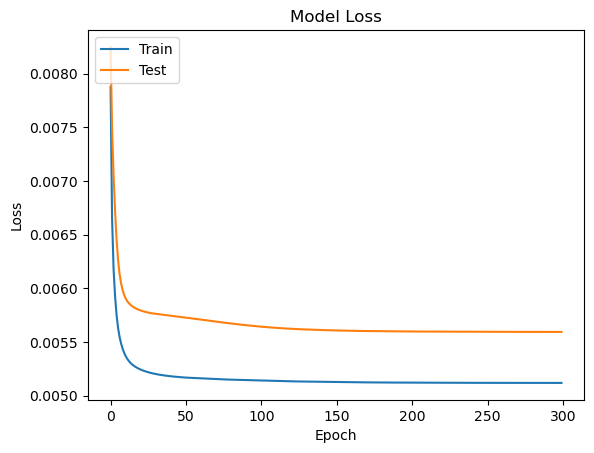

In [24]:
# Plot the loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
(188, 4, 1)
(188, 4, 1)


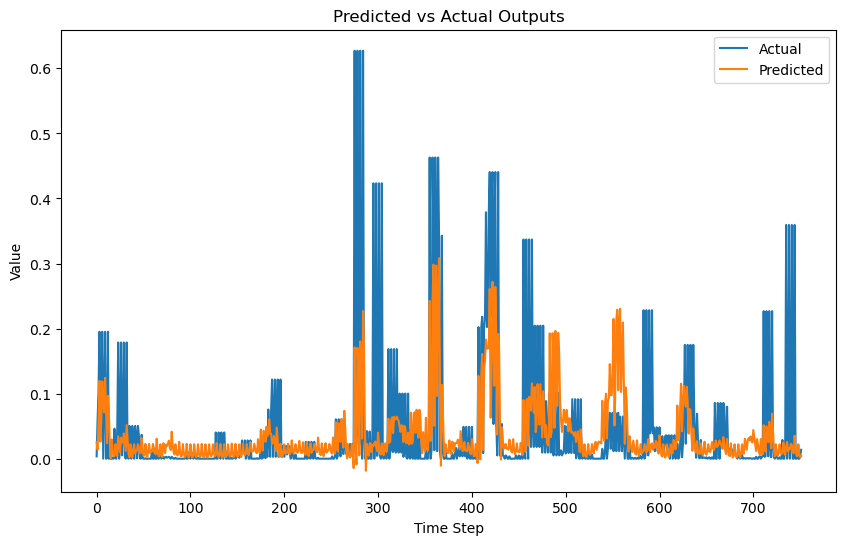

In [25]:
# Make predictions on the test set
predictions = model.predict(test_set)

# Extract the actual values from the test set
actuals = np.concatenate([y for x, y in test_set], axis=0)


print(predictions.shape)
print(actuals.shape)

# Flatten the predictions and actuals
predictions = predictions.flatten()
actuals = actuals.flatten()

# # Inverse transform the predictions and actuals
# predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).flatten()
# actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).flatten()

# Plot the predicted vs actual outputs
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Predicted vs Actual Outputs')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

     69/Unknown 0s 736us/step

429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


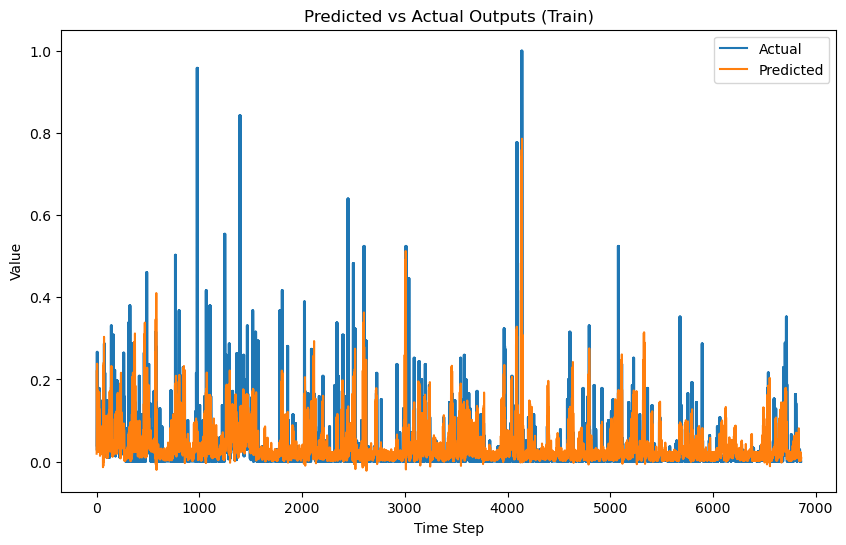

In [26]:
y_pred_train = model.predict(train_set)
y_train = np.concatenate([y for x, y in train_set], axis=0)

y_pred_train = y_pred_train.flatten()
y_train = y_train.flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_pred_train, label='Predicted')
plt.title('Predicted vs Actual Outputs (Train)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [27]:
model.save_weights('corrector-ae.weights.h5')

In [28]:
# Load the 'beirut-daily-precipitation.csv' file
beirut_df = pd.read_csv('data/beirut-daily-precipitation.csv')

# Create a windowed dataset from df['value'] without shuffling
beirut_values = beirut_df['value'].values
beirut_values = scaler.transform(beirut_values.reshape(-1, 1)).flatten()
beirut_dataset = windowed_dataset_single(beirut_values, window_size, batch_size)

# Pass the windowed dataset to the model for inference
predictions = model.predict(beirut_dataset)

# Unwrap the windows
corrected_values = predictions.flatten()

# Inverse transform the corrected values
corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 1)).flatten()

# corrected_values = scaler.inverse_transform(corrected_values.reshape(-1, 2)).flatten()
print(len(corrected_values))
print(len(beirut_df))

# Save the outputs to 'beirut-daily-corrected.csv'
beirut_df = beirut_df[:len(corrected_values)]
beirut_df['value'] = corrected_values
beirut_df.to_csv('data/beirut-daily-corrected.csv', index=False)

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
8764
8766


/home/edargham/anaconda3/envs/thesis/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
